# Lyrics detector Challenge

The goal for this challenge is to leverage your knowledge of Deep Learning to design and train a lyrics classifier. For a given verse $X$, our model should learn to predict the artist $y$. The dataset consists of lyrics scrapped from the Genius website.

### Objectives:
- Text preprocessing
- Text embedding
- Train a RNN to detect the artist behind a set of lyrics

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [11]:
# On rajoute unidecode

from unidecode import unidecode

In [41]:
import string

## 1. Data Cleaning

Our dataset contains around 4,000 verses of lyrics from different artists: Drake, Ed Sheeran and Kanye West (the verses are given in this order).

In [26]:
raw_data = pd.read_csv("https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/verses.csv")
data = raw_data.copy() # From now on, update `data` as you see fit and don't touch raw_data
data

,artist,verse
0,Drake,"Ayy, woah Ayy, ayy Yeah"
1,Drake,I'm makin' a change today The liquor been taki...
2,Drake,"I can't just be with you and only you Yeah, I ..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne..."
4,Drake,I'm makin' a change today The liquor been taki...
...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol..."
3971,Kanye West,"Then one day I just went ahead and played it, ..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot."""
3973,Kanye West,Like they still weren't looking at me like a r...


❓ **Have a look at the verse index 18th**. 
- What do you observe?
- Clean verses from non standard characters using [`unidecode.unidecode()`](https://pypi.org/project/Unidecode/)

In [27]:
data['verse'][18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I\u2005was\u2005down Now them diamonds\u2005for fun like damn Ayy, yeah'

In [28]:
# On obeserve des caractères bizarres dont il va falloire se débarrasser.

In [15]:
 unidecode(data['verse'][18])

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

In [29]:
# YOUR CODE HERE
data['verse'] =  data['verse'].apply(lambda x :unidecode(x))

In [30]:
data['verse'][18]

'Ayy, yeah Pipe this shit up and I turn this shit up When I was down, I was down Now them diamonds for fun like damn Ayy, yeah'

❓ **Check if some verses are duplicated.** 
- It can be frequent in music lyrics.
- If so, remove them to avoid data leaks between train and test sets

In [31]:
# YOUR CODE HERE
print(len(data)) 
data = data.drop_duplicates()
print(len(data))

3975
3031


In [32]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_loading',
    shape=data.shape,
    verses=data.verse[:50]
)

result.write()

## 2. Data Analysis (given to you)

👉 **We check the number of unique artist and the number of verses per artist**

In [33]:
data.artist.value_counts()

Drake         1391
Ed Sheeran     861
Kanye West     779
Name: artist, dtype: int64

👉 **For each artist, let's have a look at the top-10 most used words to see if they look similar?**

We'll use Tensorflow's [`Tokenizer`](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer)'s index_word

In [34]:
drake = data[data.artist =='Drake'].verse
ed = data[data.artist =='Ed Sheeran'].verse
kanye = data[data.artist =='Kanye West'].verse

In [35]:
tokenizer_drake = tf.keras.preprocessing.text.Tokenizer()
tokenizer_ed = tf.keras.preprocessing.text.Tokenizer()
tokenizer_kanye = tf.keras.preprocessing.text.Tokenizer()

tokenizer_drake.fit_on_texts(drake)
tokenizer_ed.fit_on_texts(ed)
tokenizer_kanye.fit_on_texts(kanye)

In [36]:
pd.DataFrame(data={
    "Drake": pd.Series(tokenizer_drake.index_word)[:10],
    "Ed Sheeran": pd.Series(tokenizer_ed.index_word)[:10],
    "Kanye West": pd.Series(tokenizer_kanye.index_word)[:10],
})

,Drake,Ed Sheeran,Kanye West
1,i,i,i
2,you,you,the
3,the,the,you
4,and,and,and
5,to,me,to
6,a,my,a
7,it,to,my
8,me,a,it
9,i'm,in,me
10,my,i'm,in


👉 **Let's quantify how much vocabulary do they have in common**

- An artist **vocabulary** is the **set** of all unique used words
- We compute the `ratio` of (i) the length of vocabulary they **share**, over (ii) the length of the **total** vocabulary of the dataset

<details>
    <summary>Hints</summary>

We'll use Python [`set.intersection()`](https://www.programiz.com/python-programming/methods/set/intersection) and [`set.union()`](https://www.programiz.com/python-programming/methods/set/union)
</details>

In [37]:
drake_vocabulary = set(tokenizer_drake.index_word.values())
ed_vocabulary = set(tokenizer_ed.index_word.values())
kanye_vocabulary = set(tokenizer_kanye.index_word.values())

In [38]:
common_vocabulary = drake_vocabulary.intersection(ed_vocabulary).intersection(kanye_vocabulary)
global_vocabulary = drake_vocabulary.union(ed_vocabulary).union(kanye_vocabulary)

ratio = len(common_vocabulary)/len(global_vocabulary)
print(f"{ratio*100:.2f}% of the artists' vocabulary is common")

15.28% of the artists' vocabulary is common


## 3. Data Preprocessing

### 3.1 Word Embedding
We now need to think about embedding our sentences into numbers. We will be using [`gensim.models.Word2Vec`](https://radimrehurek.com/gensim/models/word2vec.html#gensim.models.word2vec.Word2Vec) to embed each word of the sentence and concatenate the embeddings of the words forming the sentence.

❓ **Transform the list of strings (verses) into a list of word sequences (a word sequence is a list of words contained in a string)**
- Store these sequences of words in a new column `data["seq"]` in your dataframe
- You can use `tensorflow.keras.preprocessing.text.text_to_word_sequence` 

In [42]:
def no_punctuation(text):
    for punctuation in string.punctuation:
        text = text.replace(punctuation, '')
    return text

In [43]:
def lower_text(text):
    return text.lower()

In [45]:
def remove_number(text):
    return ''.join(word for word in text if not word.isdigit())

In [46]:
data["seq"] = data["verse"].map(no_punctuation)
data["seq"] = data["seq"].map(lower_text)
data["seq"] = data["seq"].map(remove_number)

<ipython-input-46-fe5b330628bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["seq"] = data["verse"].map(no_punctuation)
<ipython-input-46-fe5b330628bb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["seq"] = data["seq"].map(lower_text)
<ipython-input-46-fe5b330628bb>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/

In [50]:
# YOUR CODE HERE
data['seq'] = data['seq'].apply(lambda x : x.split(' '))

<ipython-input-50-50272bb30fae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq'] = data['seq'].apply(lambda x : x.split(' '))


In [52]:
data

,artist,verse,seq
0,Drake,"Ayy, woah Ayy, ayy Yeah","[ayy, woah, ayy, ayy, yeah]"
1,Drake,I'm makin' a change today The liquor been taki...,"[im, makin, a, change, today, the, liquor, bee..."
2,Drake,"I can't just be with you and only you Yeah, I ...","[i, cant, just, be, with, you, and, only, you,..."
3,Drake,"Well, summer, all I did was rest, okay? And Ne...","[well, summer, all, i, did, was, rest, okay, a..."
4,Drake,I'm makin' a change today The liquor been taki...,"[im, makin, a, change, today, the, liquor, bee..."
...,...,...,...
3970,Kanye West,"Dame was like, ""Yo you got a deal with Capitol...","[dame, was, like, yo, you, got, a, deal, with,..."
3971,Kanye West,"Then one day I just went ahead and played it, ...","[then, one, day, i, just, went, ahead, and, pl..."
3972,Kanye West,"""I ain't gonna front, it's kinda hot.""","[i, aint, gonna, front, its, kinda, hot]"
3973,Kanye West,Like they still weren't looking at me like a r...,"[like, they, still, werent, looking, at, me, l..."


❓ **Let's check if we can cap the length of each sequences without losing too much information**
- Plot the distribution of sequences lengths using the [`seaborn.kdeplot`](https://seaborn.pydata.org/generated/seaborn.displot.html#seaborn-displot) function
- Does it seem reasonable to limit ourself to 300 words per verse later on? 

In [57]:
data['len'] = data['seq'].apply(lambda x : len(x))

<ipython-input-57-dd7859eee0fd>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['len'] = data['seq'].apply(lambda x : len(x))


<AxesSubplot:xlabel='len', ylabel='Density'>

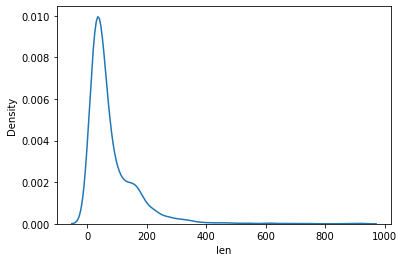

In [58]:
# YOUR CODE HERE

sns.kdeplot(data= data, x = 'len')

In [60]:
# Il semble raisonnable de garder uniquement les 300 premier mots de chaque sequence

❓ **Keep only the first `300` words of each sequences to reduce the useless long tail of long verses**

In [59]:
data['seq'] = data['seq'].apply(lambda x : x[:300])

<ipython-input-59-311382ed50bb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['seq'] = data['seq'].apply(lambda x : x[:300])


❓ **Train a `gensim.models.Word2Vec` model on your dataset** 
- You want to embed each word into vectors of dimension `100`
- No words should be excluded
- Give Word2Vec at least 50 epochs to be sure it converges
- Store these lists of vectors in a new column `data["embed"]`

In [64]:
# YOUR CODE HERE
from gensim.models import Word2Vec

word2vec = Word2Vec(sentences=data['seq'])

In [65]:
def embed_sentence(word2vec, sentence):
    liste = []
    for word in sentence :
        if word in word2vec.wv.key_to_index.keys():
            liste.append(word2vec.wv[word])
    return np.array(liste)

In [67]:
data["embed"] = data['seq'].apply(lambda x : embed_sentence(word2vec, x))

<ipython-input-67-7608788501c3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["embed"] = data['seq'].apply(lambda x : embed_sentence(word2vec, x))


0       [[-0.09148871, 0.15399598, -0.6122824, 0.58793...
1       [[-0.70677155, -0.1590439, -0.0015486102, 0.29...
2       [[0.15068203, 1.1588553, -0.29846346, 0.880694...
3       [[0.022251425, 0.21566476, -0.39192203, 0.1858...
4       [[-0.70677155, -0.1590439, -0.0015486102, 0.29...
                              ...                        
3970    [[-0.041873354, 0.1218991, -0.0060361368, 0.04...
3971    [[0.079134256, 0.62099075, -0.028839726, 0.042...
3972    [[0.15068203, 1.1588553, -0.29846346, 0.880694...
3973    [[-0.19492537, 0.52923816, 0.0645477, 0.035952...
3974    [[0.46532378, 0.94028044, -0.74225175, 0.57247...
Name: embed, Length: 3031, dtype: object

In [68]:
# Check 
assert len(data['embed']) == len(data)

### 3.2 Create (X,y)

❓ **Create your numpy array `X` of shape (number_of_verses, 300, 100)**

- 300 words per verse (pad verses shorter than 300 with zeros at the end) 
- each words being a vector of size 100

<img src="https://raw.githubusercontent.com/lewagon/data-images/master/DL/padding.png" width=400>

In [20]:
# YOUR CODE HERE

❓ **Create the numpy array `y` of shape `(n_verses, 3)` that contains the one-hot-encoded list of labels, for the RNN**

In [21]:
# YOUR CODE HERE

👉 We train/test split the dataset below for you

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [23]:
from nbresult import ChallengeResult
result = ChallengeResult(
    'data_preprocessing',
    n_zeros = np.sum(X == 0),
    X_shape = X.shape,
    y_shape = y.shape,
)

result.write()

## 4. Recurrent Neural Network

👉 Run this code below if you haven't managed to build your own (X,Y) training sets. This will load them as solution

```python
! wget \
'https://wagon-public-datasets.s3.amazonaws.com/certification_france_2021_q2/data_lyrics_solution.pickle'

import pickle
with open("data_lyrics_solution.pickle", "rb") as file:
    (X_train, y_train, X_test, y_test) = pickle.load(file)
    
! rm data_lyrics_solution.pickle
```

❓ **First, store your baseline accuracy to beat as `score_baseline`**
- Consider predicting always the most frequent artist

In [26]:
# YOUR CODE HERE

❓ **Create a RNN architecture to predict the artists `y`  given verses `X`** :

- Keep it simple: use only one LSTM layer and one *hidden* dense layer between the input and output layers
- Don't forget to take care of fake "zeros" added during preprocessing
- Store it into the `model` variable.

In [35]:
# YOUR CODE HERE

❓ **Train your `model` on the `(X_train, y_train)` training set**
- Use an appropriate loss
- Adapt the learning rate of your optimizer if convergence is too slow/fast
- Make sure your model does not overfit with appropriate control techniques

💡 You will not be judged by the computing power of your computer, you can reach decent performance in less than 3 minutes of training without GPUs.

In [36]:
# YOUR CODE HERE

❓ **Plot the training and validation losses through training**

In [37]:
# Plot below your train/val loss history
# YOUR CODE HERE
# YOUR CODE HERE
# YOUR CODE HERE


# Run also this code to save figure as jpg in path below (it's your job to ensure it works)
fig = plt.gcf()
plt.savefig("tests/history.png")

❓ **Save your accuracy on test set as `score_test`**

In [40]:
# YOUR CODE HERE

🧪 **Send your results below**

In [33]:
from nbresult import ChallengeResult

result = ChallengeResult(
    "network",
    loss = model.loss,
    input_shape = list(model.input.shape),
    layer_names = [layer.name for layer in model.layers],
    final_activation = model.layers[-1].activation.__wrapped__._keras_api_names[0],
    score_baseline = score_baseline,
    score_test = score_test,
)
result.write()